In [1]:
                                                                                                                                                                                                                                import pandas as pd
import numpy as np
import os
import shutil
import glob
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from itertools import combinations
from joblib import Parallel, delayed, dump
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from pathlib import Path
from joblib import load
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed
import gc

In [3]:
import gzip
import shutil

input_path = 'graph_LR.csv.gz'
output_path = 'graph_LR.csv'

with gzip.open(input_path, 'rb') as f_in:
    with open(output_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Preparing datasets

In [2]:
def organize_files(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".pickle"):
            parts = filename.split("_")
            subfolder_name = parts[1]
            subfolder_path = os.path.join(folder_path, subfolder_name)
            os.makedirs(subfolder_path, exist_ok=True)
            source_path = os.path.join(folder_path, filename)
            destination_path = os.path.join(subfolder_path, filename)
            shutil.move(source_path, destination_path)


In [ ]:
%cd vertices_mean_modified

In [31]:
example = pd.read_pickle('WM/LR/100206_LR_0bk.pickle')
example

,mean,std,q1,q2,q3
1,0.161901,0.905055,-0.501371,0.250854,0.831594
2,0.048376,0.930011,-0.592889,0.062303,0.717488
3,-0.030714,0.960215,-0.499960,0.005397,0.531792
4,0.168587,0.853280,-0.418951,0.209042,0.817030
5,0.040151,0.965372,-0.531460,-0.002383,0.763248
...,...,...,...,...,...
375,-0.210962,0.940451,-0.736868,-0.302718,0.430390
376,-0.144057,0.949970,-0.752839,-0.221493,0.499625
377,0.039114,0.924714,-0.604613,0.107311,0.743789
378,-0.151042,0.886143,-0.740634,-0.039249,0.393191


In [41]:
base_dir = ''
categories = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
lr_files = []
for category in categories:
    lr_dir = os.path.join(base_dir, category, 'LR')
    if os.path.exists(lr_dir):
        pattern = os.path.join(lr_dir, '*.pickle')
        files = glob.glob(pattern)
        lr_files.extend(files)

In [ ]:
categories = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
output_dir = 'vertices_mean_modified'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in categories:
    lr_dir = os.path.join(base_dir, category, 'LR')
    
    if not os.path.exists(lr_dir):
        print(f'Папка {lr_dir} не найдена.')
        continue
    
    pattern = os.path.join(lr_dir, '*.pickle')
    pickle_files = glob.glob(pattern)
    
    for file_path in pickle_files:
        try:
            with open(file_path, 'rb') as file:
                data = pd.read_pickle(file)
            
            if isinstance(data, pd.DataFrame):
                columns_to_drop = ['q1', 'q2', 'q3']
                data_modified = data.drop(columns=columns_to_drop, errors='ignore')
            
            rel_path = os.path.relpath(file_path, base_dir)
            save_path = os.path.join(output_dir, rel_path)
            save_folder = os.path.dirname(save_path)
            os.makedirs(save_folder, exist_ok=True)
            
            with open(save_path, 'wb') as file:
                pd.to_pickle(data_modified, file)
            
            print(f'Обработан и сохранён файл: {save_path}')
        
        except Exception as e:
            print(f'Ошибка при обработке файла {file_path}: {e}')



# Collect datasets

In [14]:
base_dir = 'vertices_mean_modified'  
output_dir = 'pairwise_datasets'   
pattern = os.path.join(base_dir, '**', '*.pickle')
pickle_files = glob.glob(pattern, recursive=True)

os.makedirs(output_dir, exist_ok=True)

all_files = []
for file_path in pickle_files:
    data = pd.read_pickle(file_path)
    class_label = file_path.split('_')[2].replace('.pickle', '')
    data['class'] = class_label
    data['sample_id'] = (file_path.split('_')[0]).split('/')[2]
    all_files.append(data)
   

full_data = pd.concat(all_files)

In [15]:
full_data.reset_index(inplace=True)
full_data.rename(columns={'index': 'vertex'}, inplace=True)

In [16]:
data = full_data.pivot_table(index=['sample_id', 'class'],
                              columns='vertex',
                              values=['mean', 'std'])
data

mean            ...       std          
vertex                            1         2    ...       378       379
sample_id class                                  ...                    
jupyter   modified/vertices  0.042625  0.042578  ...  0.872918  0.862617

[1 rows x 758 columns]

In [17]:
data.reset_index(inplace=True)
data.columns = [f"{feat}_{vertex}" if vertex else feat for feat, vertex in data.columns]

In [17]:
data

mean            ...       std          
vertex                            1         2    ...       378       379
sample_id class                                  ...                    
jupyter   modified/vertices  0.042625  0.042578  ...  0.872918  0.862617

[1 rows x 758 columns]

In [ ]:
vertex_columns = np.arange(1, 380)
vertex_pairs = list(combinations(vertex_columns, 2))
total_pairs = len(vertex_pairs)
print(f'Всего пар вершин: {total_pairs}')

In [133]:
def save_pairwise_dataset(pair):
    v1, v2 = pair
    cols_to_extract = [f'mean_{v1}', f'std_{v1}', f'mean_{v2}', f'std_{v2}', 'class', 'sample_id']
    subset = data[cols_to_extract].copy()
    subset.rename(columns={
        f'mean_{v1}': 'mean_v1',
        f'std_{v1}': 'std_v1',
        f'mean_{v2}': 'mean_v2',
        f'std_{v2}': 'std_v2'
    }, inplace=True)

    filename = f'dataset_v{v1}_v{v2}.pkl'
    subset.to_pickle(filename)
    return True



In [22]:
def process_pairs_in_parallel(pairs, num_processes=None):
    if num_processes is None:
        num_processes = max(1, cpu_count() - 1)  
    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.imap(save_pairwise_dataset, pairs), total=len(pairs)))
    success_count = sum(results)

In [ ]:
process_pairs_in_parallel(vertex_pairs)

# Base

In [4]:
dataset = pd.read_pickle('pairwise_datasets/dataset_v1_v2.pkl')
dataset

,mean_v1,mean_v2,std_v1,std_v2,autocorr_lag1_v1,autocorr_lag1_v2,n_peaks_v1,n_peaks_v2,mean_peak_amp_v1,mean_peak_amp_v2,mean_interpeak_interval_v1,mean_interpeak_interval_v2,class,sample_id
0,0.163564,0.045469,1.029579,0.963595,0.893819,0.464748,23.5,32.5,1.128680,1.074004,6.071146,4.514199,0bk,100206
1,0.108712,0.029340,0.917048,0.923350,0.861421,0.487011,24.5,32.0,0.956556,0.966181,5.362319,4.463950,2bk,100206
2,-0.115554,-0.176321,1.008403,1.000811,0.787456,0.512411,12.0,16.5,0.928636,0.766813,5.825000,4.137500,fear,100206
3,0.102118,0.138494,1.029514,0.881760,0.828420,0.447045,9.0,14.5,1.258415,1.085952,6.437500,3.750000,l,100206
4,0.170563,-0.001728,0.955659,0.994489,0.841642,0.583493,15.5,17.5,0.956061,0.998960,4.362745,4.159926,loss,100206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8129,0.151169,0.242556,0.939468,0.822054,0.727708,0.426522,11.5,15.0,1.141365,1.038370,5.472222,3.968750,r,996782
8130,0.407100,0.301406,1.084780,0.971230,0.792886,0.503521,11.5,15.5,1.446509,1.250261,4.888889,3.971429,relation,996782
8131,-0.158878,0.080203,0.718392,1.032309,0.695992,0.790285,13.5,17.0,0.595281,1.088634,4.954861,3.766667,rnd,996782
8132,-0.008039,0.049830,1.068128,1.098475,0.759290,0.656334,26.0,32.5,0.973631,1.079658,4.656200,4.022349,story,996782


In [5]:
unique_sample_ids = dataset['sample_id'].unique()
train_ids, test_ids = train_test_split(
    unique_sample_ids,
    test_size=0.25,
    random_state=42,
    stratify=None)

In [6]:
all_classes = ['0bk', '2bk', 'fear', 'neut', 'win', 'loss', 'l', 'r', 'match', 'relation', 'mental', 'rnd', 'math', 'story']  
le = LabelEncoder()
le.fit(all_classes)

LabelEncoder()

In [ ]:
dataset_dir = 'pairwise_datasets' 
dataset_files = [
    os.path.join(dataset_dir, fname) 
    for fname in os.listdir(dataset_dir) 
    if fname.endswith('.pkl')
]

# Experiment 1: Logistic regression base

In [15]:
def train_logistic_regression(dataset_path, model_output_dir, report_output_dir, test_size=0.25, random_state=42):    
    filename = os.path.basename(dataset_path)
    v1, v2 = filename.replace('dataset_v', '').replace('.pkl', '').split('_v')
    df = pd.read_pickle(dataset_path)
    train_data = df[df['sample_id'].isin(train_ids)].reset_index(drop=True)
    test_data = df[df['sample_id'].isin(test_ids)].reset_index(drop=True)
    
    feature_columns = ['mean_v1', 'std_v1', 'mean_v2', 'std_v2']
    X_train = train_data[feature_columns]
    y_train = train_data['class']
    X_test = test_data[feature_columns]
    y_test = test_data['class']
     

    y_train_encoded = le.transform(y_train)
    
    y_test_encoded = le.transform(y_test)
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        n_jobs=1
    )
    model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    report = classification_report(y_test_encoded, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)

    model_filename = f'logreg_v{v1}_v{v2}.joblib'
    model_path = os.path.join(model_output_dir, model_filename)
    
    report_filename = f'report_v{v1}_v{v2}.json'
    report_path = os.path.join(report_output_dir, report_filename)
    
    dump({'model': model, 'label_encoder': le}, model_path)
  
    with open(report_path, 'w') as f:
        import json
        json.dump(report, f, indent=4)
    


In [10]:
model_output_dir = 'models'
report_output_dir = 'training_reports'
os.makedirs('training_reports', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [ ]:
num_cores = os.cpu_count() - 1 if os.cpu_count() > 1 else 1


In [ ]:
results = Parallel(n_jobs=num_cores)(
    delayed(train_logistic_regression)(
        dataset_path=path, 
        model_output_dir=model_output_dir, 
        report_output_dir=report_output_dir
    ) for path in tqdm(dataset_files)
)

In [27]:
pkl_paths = []
subfolders = ['EMOTION/LR', 'GAMBLING/LR', 'LANGUAGE/LR', 'MOTOR/LR', 'RELATIONAL/LR', 'SOCIAL/LR', 'WM/LR']

base_dir = '.' 

for subfolder in subfolders:
    folder_path = os.path.join(base_dir, subfolder)  
    for test_id in test_ids:
        for filename in os.listdir(folder_path):
            if test_id in filename and filename.endswith('.pickle'):
                pkl_paths.append(os.path.join(folder_path, filename))

In [29]:
models_dir = 'models'
models = {}
for i in range(1, 380):  
    for j in range(i + 1, 380):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']

In [44]:
def process_pair(v1, v2, data_np, models):
    model = models.get((v1 + 1, v2 + 1))
    if model is None:
        raise ValueError(f"Модель для вершин ({v1}, {v2}) не найдена.")
    pair_data = np.hstack((data_np[v1], data_np[v2])).reshape(1, -1)
    probabilities = model.predict_proba(pair_data)[0]
    return probabilities

In [ ]:
correct_predictions = 0
total_files = len(pkl_paths)
prediction_results = []

for file_path in tqdm(pkl_paths):
    data = pd.read_pickle(file_path)
    data_np = data.values  
    true_class = file_path.split('_')[2].split('.')[0]
    
    results = Parallel(n_jobs=1)(
        delayed(process_pair)(i, j, data_np, models)
        for i, j in combinations(range(data_np.shape[0]), 2)
    )
    total_probabilities = np.sum(results, axis=0)
 
    average_probabilities = total_probabilities / len(results)
    predicted_class_index = np.argmax(average_probabilities)
    predicted_class = le.inverse_transform([predicted_class_index])[0]
    
    if predicted_class == true_class:
        correct_predictions += 1
    prediction_results.append({
        'file_path': file_path,
        'true_class': true_class,
        'predicted_class': predicted_class,
        'confidence': average_probabilities[predicted_class_index]
    })
    print(f"cur accuracy: {correct_predictions / len(prediction_results)} ")

accuracy = correct_predictions / total_files
print(f'Total accuracy: {accuracy:.4f}')

In [ ]:
results_df = pd.DataFrame(prediction_results)

results_df.to_csv('prediction_results.csv', index=False)

In [13]:
df = pd.read_csv('prediction_results.csv')

In [16]:
df['correct'] = df['true_class'] == df['predicted_class']
accuracy_per_class = df.groupby('true_class')['correct'].mean()
accuracy_per_class = accuracy_per_class * 100
accuracy_per_class = accuracy_per_class.rename('Accuracy (%)')
accuracy_per_class = accuracy_per_class.sort_values(ascending=False)

print("Accuracy per each class:")
print(accuracy_per_class)



Accuracy per each class:
true_class
story       94.520548
math        91.780822
mental      80.821918
rnd         78.082192
r           67.123288
2bk         66.438356
0bk         48.630137
l           47.945205
win         45.205479
loss        43.150685
neut        39.041096
match       34.246575
fear        19.863014
relation    17.808219
Name: Accuracy (%), dtype: float64


# Experiment 2: with hyperparameter optymization

In [3]:
model_output_dir = 'models_with_grid'
report_output_dir = 'training_reports_models_with_grid'
os.makedirs(model_output_dir, exist_ok=True)
os.makedirs(report_output_dir, exist_ok=True)

In [4]:
def train_logistic_regression_with_grid(dataset_path, model_output_dir, report_output_dir, test_size=0.25, random_state=42):
    
    filename = os.path.basename(dataset_path)
    v1, v2 = filename.replace('dataset_v', '').replace('.pkl', '').split('_v')
    df = pd.read_pickle(dataset_path)
    train_data = df[df['sample_id'].isin(train_ids)].reset_index(drop=True)
    test_data = df[df['sample_id'].isin(test_ids)].reset_index(drop=True)
    
    feature_columns = ['mean_v1', 'std_v1', 'mean_v2', 'std_v2']
    X_train = train_data[feature_columns]
    y_train = train_data['class']
    X_test = test_data[feature_columns]
    y_test = test_data['class']
     

    y_train_encoded = le.transform(y_train)
    
    y_test_encoded = le.transform(y_test)
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        n_jobs=1
    )
    
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga'],
        'penalty': ['l2']
    }
    
    grid = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='f1_weighted',  
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train_encoded)
    
    best_model = grid.best_estimator_
   
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test_encoded, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)

    model_filename = f'logreg_v{v1}_v{v2}.joblib'
    model_path = os.path.join(model_output_dir, model_filename)
    
    report_filename = f'report_v{v1}_v{v2}.json'
    report_path = os.path.join(report_output_dir, report_filename)
    
    dump({'model': best_model, 'label_encoder': le}, model_path)
  
    with open(report_path, 'w') as f:
        import json
        json.dump(report, f, indent=4)
    


In [ ]:
results = Parallel(n_jobs=num_cores)(
    delayed(train_logistic_regression_with_grid)(
        dataset_path=path, 
        model_output_dir=model_output_dir, 
        report_output_dir=report_output_dir
    ) for path in tqdm(dataset_files)
)

In [17]:
models_dir = 'models_with_grid'
models = {}
for i in range(1, 380):  
    for j in range(i + 1, 380):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']

In [64]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
correct_predictions = 0
total_files = len(pkl_paths)
prediction_results = []

for file_path in tqdm(pkl_paths):
    data = pd.read_pickle(file_path)
    data_np = data.values  
    true_class = file_path.split('_')[2].split('.')[0]
    
    results = Parallel(n_jobs=1)(
        delayed(process_pair)(i, j, data_np, models)
        for i, j in combinations(range(data_np.shape[0]), 2)
    )
    total_probabilities = np.sum(results, axis=0)
 
    average_probabilities = total_probabilities / len(results)
    predicted_class_index = np.argmax(average_probabilities)
    predicted_class = le.inverse_transform([predicted_class_index])[0]
    
    if predicted_class == true_class:
        correct_predictions += 1
    prediction_results.append({
        'file_path': file_path,
        'true_class': true_class,
        'predicted_class': predicted_class,
        'confidence': average_probabilities[predicted_class_index]
    })
    print(f"cur accuracy: {correct_predictions / len(prediction_results)} ")

accuracy = correct_predictions / total_files
print(f'Total accuracy: {accuracy:.4f}')

In [ ]:
results_df = pd.DataFrame(prediction_results)

results_df.to_csv('prediction_results_with_grid.csv', index=False)
print("Prediction results have been saved to 'prediction_results.csv'.")

In [36]:
df = pd.read_csv('prediction_results_with_grid.csv')
df['correct'] = df['true_class'] == df['predicted_class']
accuracy_per_class = df.groupby('true_class')['correct'].mean()
accuracy_per_class = accuracy_per_class * 100
accuracy_per_class = accuracy_per_class.rename('Accuracy (%)')
accuracy_per_class = accuracy_per_class.sort_values(ascending=False)

print("Accuracy per each class:")
print(accuracy_per_class)



Accuracy per each class:
true_class
story       94.520548
math        91.780822
mental      80.821918
rnd         79.452055
r           69.178082
2bk         67.808219
0bk         50.000000
l           48.630137
win         45.890411
loss        43.150685
neut        38.356164
match       36.986301
fear        20.547945
relation    18.493151
Name: Accuracy (%), dtype: float64


# Analysis of predictions

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

df = pd.read_csv('prediction_results_with_grid.csv') 

In [4]:


cm = confusion_matrix(df['true_class'], df['predicted_class'])

print(classification_report(df['true_class'], df['predicted_class']))

              precision    recall  f1-score   support

         0bk       0.74      0.50      0.60       146
         2bk       0.70      0.68      0.69       146
        fear       0.54      0.21      0.30       146
           l       0.62      0.49      0.55       146
        loss       0.44      0.43      0.43       146
       match       0.64      0.37      0.47       146
        math       0.61      0.92      0.73       146
      mental       0.78      0.81      0.79       146
        neut       0.50      0.38      0.43       146
           r       0.43      0.69      0.53       146
    relation       0.71      0.18      0.29       146
         rnd       0.53      0.79      0.63       146
       story       0.64      0.95      0.76       146
         win       0.31      0.46      0.37       146

    accuracy                           0.56      2044
   macro avg       0.58      0.56      0.54      2044
weighted avg       0.58      0.56      0.54      2044



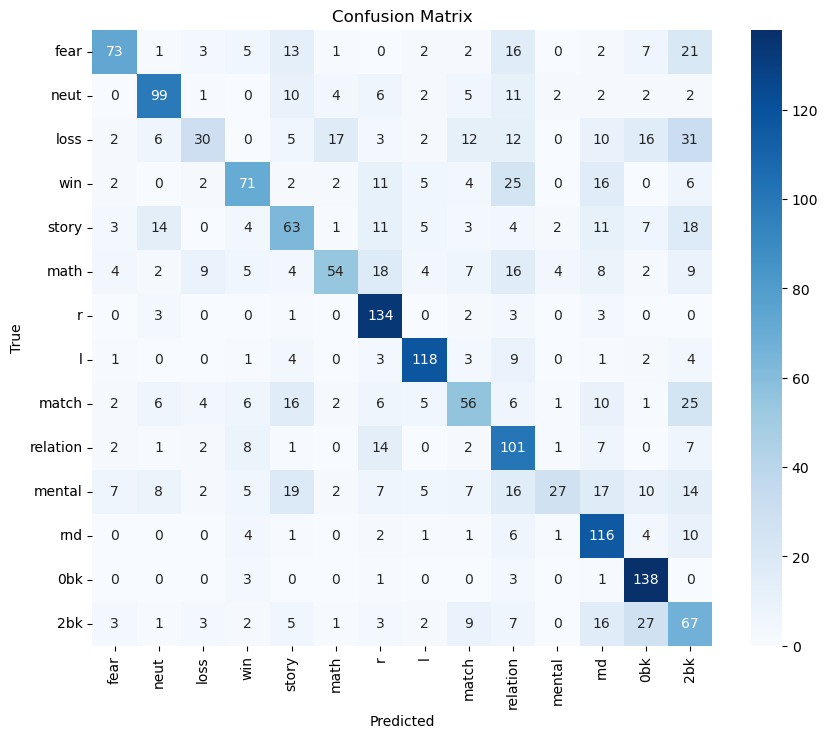

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=df['true_class'].unique(), 
            yticklabels=df['true_class'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

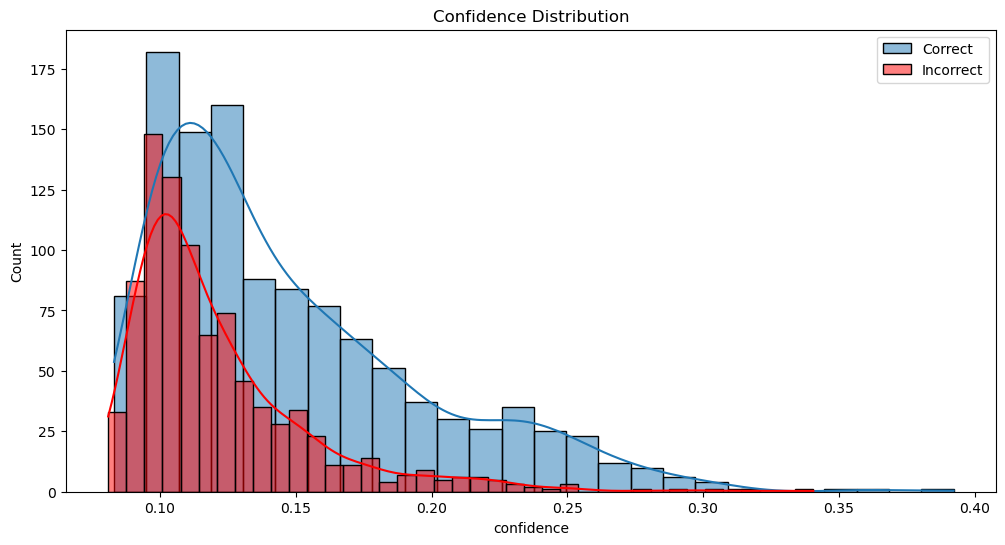

In [8]:
correct = df[df['true_class'] == df['predicted_class']]['confidence']
incorrect = df[df['true_class'] != df['predicted_class']]['confidence']

plt.figure(figsize=(12, 6))
sns.histplot(correct, label='Correct', kde=True)
sns.histplot(incorrect, label='Incorrect', kde=True, color='red')
plt.title('Confidence Distribution')
plt.legend()
plt.show()

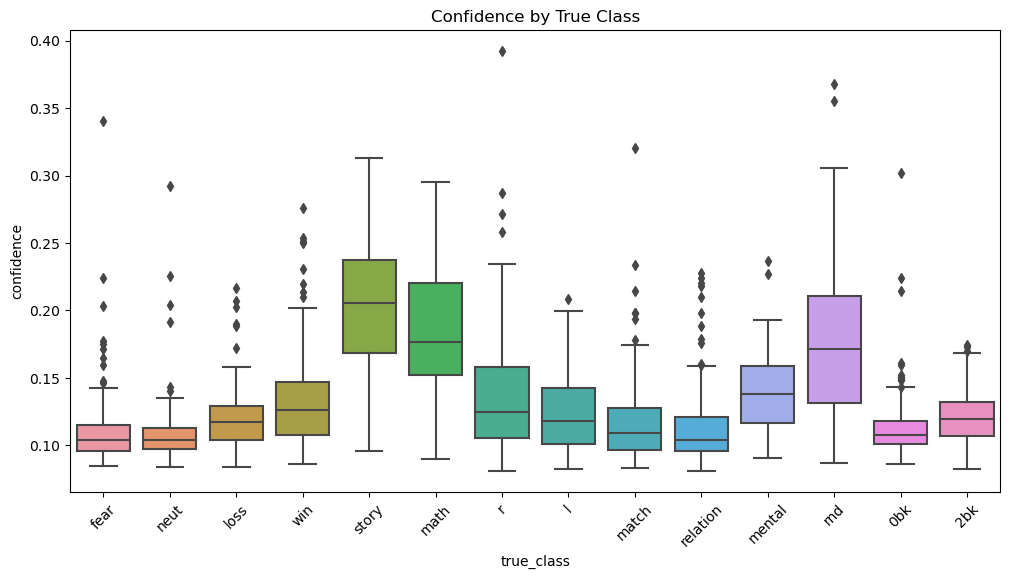

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='true_class', y='confidence', data=df)
plt.title('Confidence by True Class')
plt.xticks(rotation=45)
plt.show()

In [13]:
print("Most common errors:")
error_pairs = df[df['true_class'] != df['predicted_class']].groupby(
    ['true_class', 'predicted_class']
).size().sort_values(ascending=False)
print(error_pairs.head(10))

Most common errors:
true_class  predicted_class
fear        win                31
win         story              27
l           r                  25
neut        win                25
0bk         win                21
relation    loss               19
loss        win                18
match       math               18
relation    rnd                17
fear        match              17
dtype: int64
